In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

In [12]:

# La API de Our World in Data requiere que nos identifiquemos.
# Esto es para que el servidor sepa quién está descargando.
USER_AGENT = {"User-Agent": "Our World In Data data fetch/1.0"}
# URL template: the {} will be replaced by the chart's short name (slug).
BASE_URL = "https://ourworldindata.org/grapher/{}.csv?v=1&csvType=full&useColumnShortNames=true"

# Dictionary of the 6 datasets
DATASETS = {
    "accumulated_waste": "plastic-waste-accumulated-in-oceans",
    "microplastics_global": "microplastics-in-ocean",
    "sea_temp_anomaly": "sea-surface-temperature-anomaly",
    "production_projections": "global-plastic-production-projections",
    "production_historical": "global-plastics-production",
    "emitted_share": "share-of-global-plastic-waste-emitted-to-the-ocean"
}

Accumulated Waste in Europe 

In [13]:
# Use the same USER_AGENT for all requests
USER_AGENT = {"User-Agent": "Our World In Data data fetch/1.0"}

# Indicate which dataset to download
dataset_name = "accumulated_waste"
slug = DATASETS[dataset_name]  # this gives "plastic-waste-accumulated-in-oceans"

# Full URL
url = f"https://ourworldindata.org/grapher/{slug}.csv?v=1&csvType=full&useColumnShortNames=true"

# Download the full DataFrame, without filters
df_accumulated_waste = pd.read_csv(url, storage_options=USER_AGENT)


In [14]:
df_accumulated_waste.shape 

(200, 4)

In [15]:
df_accumulated_waste.columns.tolist()

['Entity', 'Code', 'Year', 'value__leakage_type_accumulated_stock_in_oceans']

In [16]:
df_accumulated_waste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Entity                                           200 non-null    object 
 1   Code                                             80 non-null     object 
 2   Year                                             200 non-null    int64  
 3   value__leakage_type_accumulated_stock_in_oceans  200 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.4+ KB


In [22]:
# Delete 'Code' column 
if 'Code' in df_accumulated_waste.columns:
    df_accumulated_waste = df_accumulated_waste.drop(columns=['Code'])
    
# Rename columns for clarity
df_accumulated_waste = df_accumulated_waste.rename(columns={
    'value__leakage_type_accumulated_stock_in_oceans': 'accumulated_mtonnes',
    "entity" : "continent",
})
# Standardize column names
df_accumulated_waste.columns = df_accumulated_waste.columns.str.lower().str.replace(' ', '_', regex=False)

# Transform the total accumulated waste from tonnes to million tonnes
df_accumulated_waste['accumulated_million_tonnes'] = df_accumulated_waste['accumulated_mtonnes'] / 1_000_000

In [18]:
df_accumulated_waste.columns.tolist()

['entity', 'year', 'accumulated_mtonnes', 'accumulated_million_tonnes']

In [19]:
df_accumulated_waste.head()

,entity,year,accumulated_mtonnes,accumulated_million_tonnes
0,Americas (excl. USA),2000,1104799.0,1.104799
1,Americas (excl. USA),2001,1198096.0,1.198096
2,Americas (excl. USA),2002,1298042.0,1.298042
3,Americas (excl. USA),2003,1404860.0,1.404860
4,Americas (excl. USA),2004,1519021.0,1.519021


In [23]:
sorted(df_accumulated_waste['continent'].unique())

['Americas (excl. USA)',
 'Asia (excl. China and India)',
 'China',
 'Europe',
 'India',
 'Middle East & North Africa',
 'Oceania',
 'Sub-Saharan Africa',
 'United States',
 'World']

In [24]:
# Extraer datos de Europa
df_europa = df_accumulated_waste[df_accumulated_waste['continent'] == 'Europe']

# Extraer datos del resto (todo menos Europa)
df_resto = df_accumulated_waste[df_accumulated_waste['continent'] != 'Europe']

# Crear tabla con la suma total del "resto" por año
df_resto_agregado = df_resto.groupby('year')['accumulated_million_tonnes'].sum().reset_index()
df_resto_agregado.rename(columns={'accumulated_million_tonnes': 'rest_of_world_million_tonnes'}, inplace=True)

# Unir Europa con el resto por año
df_comparativa = df_europa[['year', 'accumulated_million_tonnes']].rename(
    columns={'accumulated_million_tonnes': 'europe_million_tonnes'}
).merge(df_resto_agregado, on='year', how='outer').sort_values('year').reset_index(drop=True)

# Opcional: añadir proporción de Europa respecto al total
df_comparativa['total'] = df_comparativa['europe_million_tonnes'] + df_comparativa['rest_of_world_million_tonnes']
df_comparativa['europe_share_pct'] = (df_comparativa['europe_million_tonnes'] / df_comparativa['total']) * 100

# Mostrar la tabla completa
print("\n Comparativa anual: Europa vs. Resto del mundo (millones de toneladas)")
print(" ")
print(df_comparativa.to_string(index=False, float_format="%.2f"))


 Comparativa anual: Europa vs. Resto del mundo (millones de toneladas)
 
 year  europe_million_tonnes  rest_of_world_million_tonnes  total  europe_share_pct
 2000                   2.11                         14.84  16.94             12.44
 2001                   2.24                         16.07  18.31             12.22
 2002                   2.37                         17.39  19.76             11.99
 2003                   2.51                         18.81  21.31             11.76
 2004                   2.65                         20.32  22.96             11.52
 2005                   2.79                         21.92  24.71             11.29
 2006                   2.94                         23.63  26.57             11.05
 2007                   3.09                         25.45  28.54             10.82
 2008                   3.24                         27.37  30.61             10.59
 2009                   3.40                         29.38  32.78             10.37
 2

In [ ]:
! pip install matplotlib

import matplotlib.pyplot as plt

In [25]:
# Filtrar solo el último año (normalmente 2019)
last_year = df_accumulated_waste['year'].max()
df_last_year = df_accumulated_waste[df_accumulated_waste['year'] == last_year].copy()

# Ordenar de mayor a menor contaminación
df_last_year = df_last_year[['continent', 'accumulated_million_tonnes']].sort_values(
    'accumulated_million_tonnes', ascending=False
).reset_index(drop=True)
df_last_year.sort_values('accumulated_million_tonnes', ascending=False)
print(f"\n Comparativa de todos los continentes en {last_year}:")
print(" ")
print(df_last_year.to_string(index=False, float_format="%.2f"))


 Comparativa de todos los continentes en 2019:
 
                   continent  accumulated_million_tonnes
                       World                       30.41
Asia (excl. China and India)                        7.82
                      Europe                        5.05
        Americas (excl. USA)                        4.21
                       China                        3.90
               United States                        3.35
          Sub-Saharan Africa                        2.98
  Middle East & North Africa                        1.84
                       India                        1.22
                     Oceania                        0.03


DF2: Microplásticos Globales

In [26]:
# Use the same USER_AGENT for all requests
USER_AGENT = {"User-Agent": "Our World In Data data fetch/1.0"}

# Indicate which dataset to download
dataset_name = "microplastics_global"
slug = DATASETS[dataset_name]  # this gives "microplastics-in-ocean"

# Full URL
url = f"https://ourworldindata.org/grapher/{slug}.csv?v=1&csvType=full&useColumnShortNames=true"

# Download the full DataFrame, without filters
df_microplastics_global = pd.read_csv(url, storage_options=USER_AGENT)



In [ ]:
df_microplastics_global.shape

In [ ]:
df_microplastics_global.columns.tolist()

In [ ]:
df_microplastics_global.info()

In [32]:
# Delete 'Code' column 
if 'Code' in df_microplastics_global.columns:
    df_microplastics_global = df_microplastics_global.drop(columns=['Code'])
# Rename columns for clarity
df_microplastics_global = df_microplastics_global.rename(columns={
    "Accumulated ocean plastic: Microplastics (<0.5cm)" :"tonnes_microplastics",
})
# Standardize column names
df_microplastics_global.columns = df_microplastics_global.columns.str.lower().str.replace(' ', '_', regex=False)

In [33]:
# Filter for rage of years 1990 to 2019
df_microplastics_global = df_microplastics_global[
    (df_microplastics_global['year'] >= 1990) & (df_microplastics_global['year'] <= 2019)
]

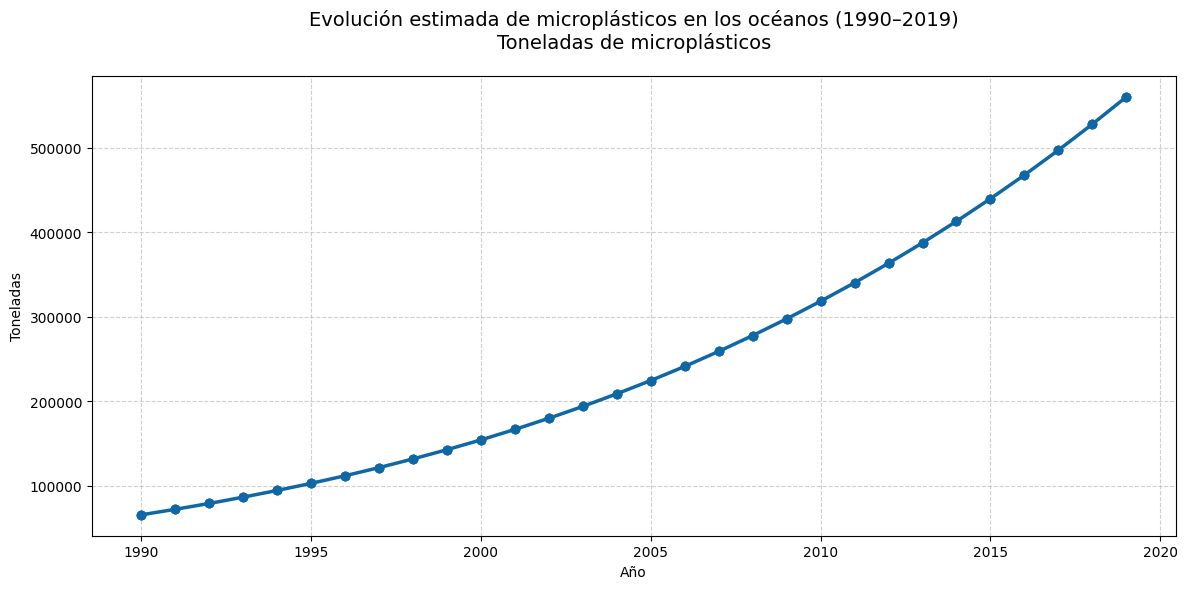

In [34]:
import matplotlib.pyplot as plt

# Sort data by year
df_plot = df_microplastics_global[
    (df_microplastics_global['year'] >= 1990) & (df_microplastics_global['year'] <= 2019)
].sort_values('year')

plt.figure(figsize=(12, 6))
plt.plot(df_plot['year'], df_plot['tonnes_microplastics'], 
         marker='o', linewidth=2.5, color="#0f67a6")

plt.title('Evolución estimada de microplásticos en los océanos (1990–2019)\n'
          'Toneladas de microplásticos', fontsize=14, pad=20)
plt.xlabel('Año')
plt.ylabel('Toneladas')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

“La masa estimada de microplásticos en la superficie de los océanos ha pasado de < 20,000 toneladas en 1990 a más de 500,000 toneladas en 2019, un aumento de más de 25 veces en casi 40 años."

DF3: Anomalía de Temperatura Global 

Production Projections (Europe)

Global Historical Production (Production Context)

Share of Emitted Waste (Single Data Point)